In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

In [3]:
url = "https://zenodo.org/record/15854383/files/MEGADATA.xlsx"
df = pd.read_excel(url)

df.head()

,CROP,Α.Μ.Δ,ΒΑΘΟΣ,Soil texture,S,C,Si,pH,Ec,O.O.,...,NO3-N,P,K,Mg,Ca,Fe,Zn,Mn,Cu,B
0,Olive non irrigated,251001,NaN,L,44.0,22.0,34.0,7,0.479,3.57,...,17.92,44.85,420.0,1001.0,1008,53.92,5.96,10.51,63.12,1.24
1,Olive non irrigated,251002,NaN,SL,54.0,18.0,28.0,5.15,0.722,3.08,...,31.44,46.05,485.0,263.0,1360,67.98,1.75,47.42,14.78,1.5
2,Olive non irrigated,251003,NaN,CL,30.0,30.0,40.0,7.31,0.557,2.57,...,14,3.94,243.0,656.0,>2000,5.62,0.36,4.48,3.22,0.35
3,Olive non irrigated,251004,NaN,SL,68.0,16.0,16.0,5.64,0.747,2.99,...,20.83,15.75,99.0,157.0,672,45.03,7.32,12.07,7.98,1.69
4,Olive irrigated,251005,NaN,L,48.0,22.0,30.0,7.11,0.559,3.13,...,9.07,17.13,210.0,547.0,>2000,4.61,2.06,6.72,68.03,0.58


In [4]:
def classify_soil(texture):
    clayey = ["C", "CL", "SiC", "SiCL", "SC"]
    loamy  = ["L", "SiL", "SCL"]
    sandy  = ["S", "LS", "SL"]

    if texture in clayey:
        return "Clayey"
    elif texture in loamy:
        return "Loamy"
    elif texture in sandy:
        return "Sandy"
    else:
        return "Unknown"  # Or np.nan if you prefer

# Apply the function to create a new column
df['Soil Classification'] = df['Soil texture'].apply(classify_soil)

In [5]:
# Count of NaN values in each column
nan_summary = df.isna().sum()

# Filter only columns with at least one NaN
nan_columns = nan_summary[nan_summary > 0]

print("Columns with missing values:")
print(nan_columns)

Columns with missing values:
CROP            1276
Α.Μ.Δ           1301
ΒΑΘΟΣ           9459
Soil texture       3
     pH            9
     Ec           10
 O.O.             26
 CaCO3             2
NO3               35
NO3-N             31
 P                31
  K               31
Mg                31
Ca                31
  Fe              44
Zn                44
Mn                44
   Cu             44
B                 33
dtype: int64


In [6]:
df.columns = df.columns.str.strip()

In [7]:
# Define the list of required columns (after stripping spaces)
required_columns = [
    'Soil texture', 'S', 'C', 'Si', 'pH', 'Ec', 'O.O.', 'CaCO3',
    'NO3', 'NO3-N', 'P', 'K', 'Mg', 'Ca', 'Fe', 'Zn', 'Mn', 'Cu', 'B'
]

# Drop rows with NaNs in any of the required columns
df_cleaned = df.dropna(subset=required_columns)

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
for col in df_cleaned.select_dtypes(include='object').columns:
    df_cleaned[col] = df_cleaned[col].astype(str).str.replace(',', '.', regex=False)
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='ignore')  # Keeps invalid values as strings

In [10]:
target_columns = ['S', 'C', 'Si', 'pH', 'Ec', 'O.O.', 'CaCO3',
                  'NO3-N', 'P', 'K', 'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B']

# Convert strings to NaN, and keep numeric values
for col in target_columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

In [11]:
# List of columns to check
target_columns = ['S', 'C', 'Si', 'pH', 'Ec', 'O.O.', 'CaCO3',
                  'NO3-N', 'P', 'K', 'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B']

# Count NaNs in each column
nan_counts = df_cleaned[target_columns].isna().sum()

print("Number of NaN values per column:")
print(nan_counts)

Number of NaN values per column:
S         0
C         0
Si        0
pH        4
Ec        1
O.O.      4
CaCO3     3
NO3-N     0
P         4
K         0
Mg        0
Fe        1
Zn        0
Mn        0
Cu        1
B        18
dtype: int64


In [12]:
target_columns = ['S', 'C', 'Si', 'pH', 'Ec', 'O.O.', 'CaCO3',
                  'NO3-N', 'P', 'K', 'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B']

# Drop rows with NaNs in those columns
df_cleaned = df_cleaned.dropna(subset=target_columns)

In [13]:
df_expanded = df_cleaned.copy()

In [14]:
df_expanded.rename(columns={'O.O.': 'Organic matter', 'Ec': 'EC'}, inplace=True)

In [15]:
X_input = df_expanded[['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu']]

In [18]:
df_expanded.shape

(10392, 23)

In [19]:
nan_counts = df_expanded.isna().sum()
print("NaN count per column:")
print(nan_counts[nan_counts > 0])  # show only columns with NaNs

NaN count per column:
Series([], dtype: int64)


In [20]:
url = "https://zenodo.org/record/15854383/files/soil_phosphorus_adsorption_data.xlsx"
df = pd.read_excel(url)

df.head()

,id,code,Soil Classification,Soil texture,C,Si,S,pH,EC,CaCO3,...,1ppm_applied,2ppm_applied,4ppm_applied,6ppm_applied,10ppm_applied,1ppm_adsorbed,2ppm_adsorbed,4ppm_adsorbed,6ppm_adsorbed,10ppm_adsorbed
0,4,1053,Loamy,SCL,24,24,52,4.54,0.336,0.0,...,5.35860,10.7172,21.4344,32.1516,53.5860,5.216276,10.311822,20.682160,31.260304,52.135641
1,5,1055,Loamy,SL,20,28,52,5.76,0.449,0.0,...,5.39295,10.7859,21.5718,32.3577,53.9295,5.341016,10.336667,20.503187,30.689553,50.442041
2,6,1057,Loamy,CL,32,24,44,4.95,0.244,0.0,...,5.15250,10.3050,20.6100,30.9150,51.5250,5.058673,10.213389,20.295749,30.403460,50.937100
3,7,1059,Loamy,SCL,28,24,48,4.80,0.265,0.0,...,5.22120,10.4424,20.8848,31.3272,52.2120,5.174940,10.246448,20.405650,30.795369,50.953534
4,51,1069,Loamy,L,18,34,48,7.48,0.397,20.8,...,5.11815,10.2363,20.4726,30.7089,51.1815,4.479507,9.494015,18.376922,26.764393,39.527575


In [21]:
#convert to kg/ha
df['1ppm_adsorbed'] = 10 * df['1ppm_adsorbed']
df['2ppm_adsorbed'] = 10 * df['2ppm_adsorbed']
df['4ppm_adsorbed'] = 10 * df['4ppm_adsorbed']
df['6ppm_adsorbed'] = 10 * df['6ppm_adsorbed']
df['10ppm_adsorbed'] = 10 * df['10ppm_adsorbed']

In [22]:
# convert absorbed P to mg/kg of soil
df['1ppm_adsorbed'] = (df['1ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['2ppm_adsorbed'] = (df['2ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['4ppm_adsorbed'] = (df['4ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['6ppm_adsorbed'] = (df['6ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['10ppm_adsorbed'] = (df['10ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)

In [23]:
#selected features from feature engineering notebook
df_final_input = df[['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu','1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']]

In [24]:
X = df_final_input.drop(columns=['1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed'])
y = df_final_input[['1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Initialize an XGBRegressor model with native multi-output support
model_multi = xgb.XGBRegressor(n_estimators=257,
                     learning_rate=0.13746153625886032,
                     tree_method="hist",
                     multi_strategy="multi_output_tree",
                     max_depth= 8,
                     min_child_weight = 2,
                     subsample= 0.8575279805203573,
                     colsample_bytree = 0.8978546705230994,
                     gamma = 2.4634384973190855,
                     random_state=42)

In [27]:
#train the multioutput xgboost model based on the phosphorus adsorption dataset
model_multi.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8978546705230994, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.4634384973190855,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.13746153625886032,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=257, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
# predict phosphorus adsorption for the extended dataset
y_pred = model_multi.predict(X_input)

In [29]:
# 1. Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['XGBoost_1ppm_adsorbed', 'XGBoost_2ppm_adsorbed', 'XGBoost_4ppm_adsorbed', 'XGBoost_6ppm_adsorbed', 'XGBoost_10ppm_adsorbed'])

In [30]:
# 2. Reset index (optional, if needed for alignment)
y_pred_df.reset_index(drop=True, inplace=True)
df_expanded.reset_index(drop=True, inplace=True)

# 3. Concatenate to df_final
df_expanded = pd.concat([df_expanded, y_pred_df], axis=1)

In [31]:
df_expanded = df_expanded[~df_expanded['Α.Μ.Δ'].isin(['212785', '192470', '193250'])]

In [32]:
df_expanded.shape

(10389, 28)

In [33]:
#get langmuir parameters from the phosphorus analysis notebook

# Langmuir parameters
texture_params = {
    "C":    (16366.058934, 0.005949),
    "CL":   (14959.937394, 0.006133),
    "L":    (12055.405405, 0.007546),
    "LS":   (2803.550024, 0.025078),
    "SCL":  (8517.247429, 0.010916),
    "SL":   (4998.743467, 0.017967),
    "SiC":  (6686.859738, 0.013785),
    "SiCL": (6840.715595, 0.014428),
    "SiL":  (104509.787289, 0.000841)
}

classification_params = {
    "Clayey": (11822.862819, 0.007950),
    "Loamy":  (12899.800247, 0.007242),
    "Sandy":  (8231.606950, 0.010547)
}

# Langmuir function
def langmuir(Ce, Qm, K):
    return (Qm * K * Ce) / (1 + K * Ce)

# Ce values
Ce_values = [1, 2, 4, 6, 10]

# Mapping Ce to XGBoost column
ce_to_xgb_col = {
    1: 'XGBoost_1ppm_adsorbed',
    2: 'XGBoost_2ppm_adsorbed',
    4: 'XGBoost_4ppm_adsorbed',
    6: 'XGBoost_6ppm_adsorbed',
    10: 'XGBoost_10ppm_adsorbed'
}

# Collect new rows
expanded_predictions = []

for _, row in df_expanded.iterrows():
    texture = row['Soil texture']
    classification = row['Soil Classification']

    if texture in texture_params:
        Qm, K = texture_params[texture]
        used = 'Texture'
        used_texture_param = True
    elif classification in classification_params:
        Qm, K = classification_params[classification]
        used = 'Classification'
        used_texture_param = False
    else:
        Qm, K = np.nan, np.nan
        used = 'None'
        used_texture_param = np.nan

    for Ce in Ce_values:
        if not np.isnan(Qm):
            q = langmuir(Ce, Qm, K)
        else:
            q = np.nan

        # Get corresponding XGBoost prediction
        xgb_col = ce_to_xgb_col[Ce]
        xgb_pred = row.get(xgb_col, np.nan)

        # Copy row and add values
        new_row = row.copy()
        new_row['Ce'] = Ce
        new_row['P_adsorption'] = q
        new_row['XGBoost_P_adsorption'] = xgb_pred
        new_row['Used Params From'] = used
        new_row['Used Texture Params'] = used_texture_param

        expanded_predictions.append(new_row)

# Final expanded dataframe
df_expanded_10 = pd.DataFrame(expanded_predictions)


In [34]:
df_final2 = df_expanded_10.copy()

In [35]:
# Correct erroneously recorded phosphorus (P) values in the extended dataset
df_final2['P'] = df_final2['P'].replace(1308.5, 130.9)
df_final2['P'] = df_final2['P'].replace(676.4, 67.5)
df_final2['P'] = df_final2['P'].replace(605.57, 60.5)
print("Max P after replacement:", df_final2['P'].max())

Max P after replacement: 360.44


In [36]:
nan_counts = df_final2.isna().sum()
print("NaN count per column:")
print(nan_counts[nan_counts > 0])  # show only columns with NaNs

NaN count per column:
Series([], dtype: int64)


In [37]:
df_final2.rename(columns={'P_adsorption': 'Langmuir'}, inplace=True)
df_final2.rename(columns={'XGBoost_P_adsorption': 'XGBoost'}, inplace=True)

C:\Users\miatr\AppData\Local\Temp\ipykernel_10948\3047662446.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_final2.groupby('P_bin').agg(


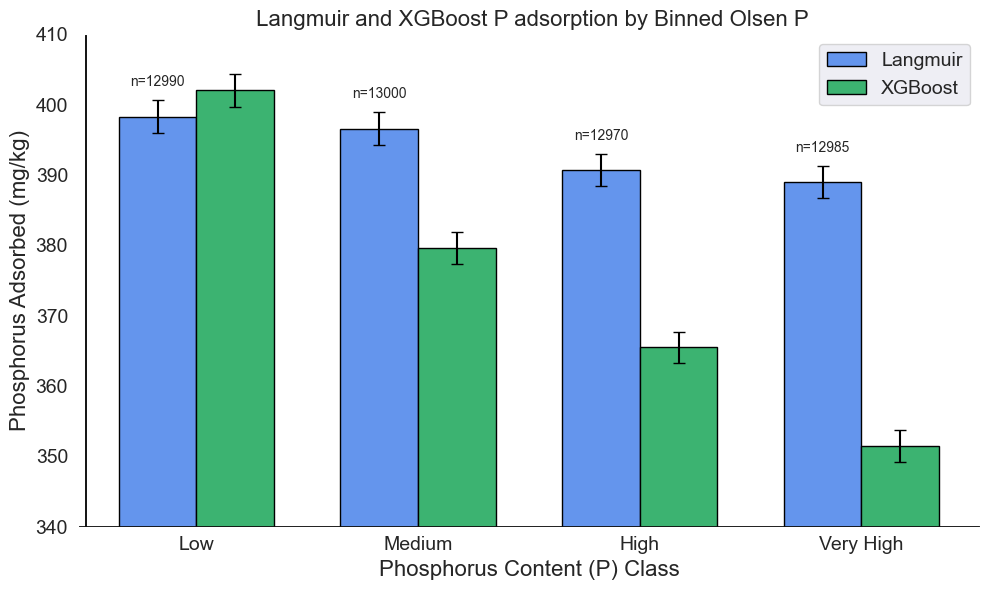

In [39]:
# --- Step 1: Bin P into 4 quantile-based categories ---
df_final2['P_bin'] = pd.qcut(df_final2['P'], q=4, labels=["Low", "Medium", "High", "Very High"])

# --- Step 2: Group and calculate mean and standard error ---
summary = df_final2.groupby('P_bin').agg(
    P_adsorption_mean=('Langmuir', 'mean'),
    P_adsorption_sem=('Langmuir', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    q_mean=('XGBoost', 'mean'),
    q_sem=('XGBoost', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    n=('XGBoost', 'count')
).reset_index()

# --- Step 3: Plot the grouped bars with error bars ---
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

x = np.arange(len(summary))  # x positions
width = 0.35  # bar width

# Plot P_adsorption bars
ax.bar(x - width/2, summary['P_adsorption_mean'], width,
       yerr=summary['P_adsorption_sem'], capsize=4,
       label='Langmuir', color='cornflowerblue', edgecolor='black')

# Plot q bars
ax.bar(x + width/2, summary['q_mean'], width,
       yerr=summary['q_sem'], capsize=4,
       label='XGBoost', color='mediumseagreen', edgecolor='black')

# --- Labels and styling ---
ax.set_xticks(x)
ax.set_xticklabels(summary['P_bin'], fontsize=14)
ax.set_ylabel("Phosphorus Adsorbed (mg/kg)", fontsize=16)
ax.set_xlabel("Phosphorus Content (P) Class", fontsize=16)
ax.set_title(" Langmuir and XGBoost P adsorption by Binned Olsen P", fontsize=16)
ax.legend(fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(340, 410)
ax.tick_params(axis='both', labelsize=14)

# Draw X and Y axis lines
ax.axhline(y=340, color='black', linewidth=1.3)
ax.axvline(x=-0.5, color='black', linewidth=1.3)  # start of x-axis

# --- Annotate with sample size ---
for i, row in summary.iterrows():
    ax.text(x[i] - width/2, row['P_adsorption_mean'] + row['P_adsorption_sem'] + 2,
            f"n={row['n']}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [40]:
print(summary)

       P_bin  P_adsorption_mean  P_adsorption_sem      q_mean     q_sem      n
0        Low         398.319767          2.357534  402.057837  2.345667  12990
1     Medium         396.565218          2.344890  379.638174  2.265116  13000
2       High         390.728511          2.305205  365.481697  2.267818  12970
3  Very High         389.017150          2.289470  351.492604  2.246134  12985


In [41]:
from scipy.stats import f_oneway

# Filter the two groups
low_group = df_final2[df_final2['P_bin'] == 'Low']['Langmuir'].dropna()
very_high_group = df_final2[df_final2['P_bin'] == 'Very High']['Langmuir'].dropna()

# Perform one-way ANOVA
f_stat, p_value = f_oneway(low_group, very_high_group)

print(f"ANOVA results:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")

ANOVA results:
F-statistic = 8.013, p-value = 0.00465


In [42]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(low_group, very_high_group, equal_var=False)
print(f"Welch's t-test:\nt = {t_stat:.3f}, p = {p_val:.5f}")

Welch's t-test:
t = 2.831, p = 0.00465


In [43]:
from scipy.stats import f_oneway

# Filter the two groups
low_group = df_final2[df_final2['P_bin'] == 'Low']['XGBoost'].dropna()
very_high_group = df_final2[df_final2['P_bin'] == 'Very High']['XGBoost'].dropna()

# Perform one-way ANOVA
f_stat, p_value = f_oneway(low_group, very_high_group)

print(f"ANOVA results:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")

ANOVA results:
F-statistic = 242.413, p-value = 0.00000


C:\Users\miatr\AppData\Local\Temp\ipykernel_10948\29444353.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_final2.groupby('S_bin').agg(


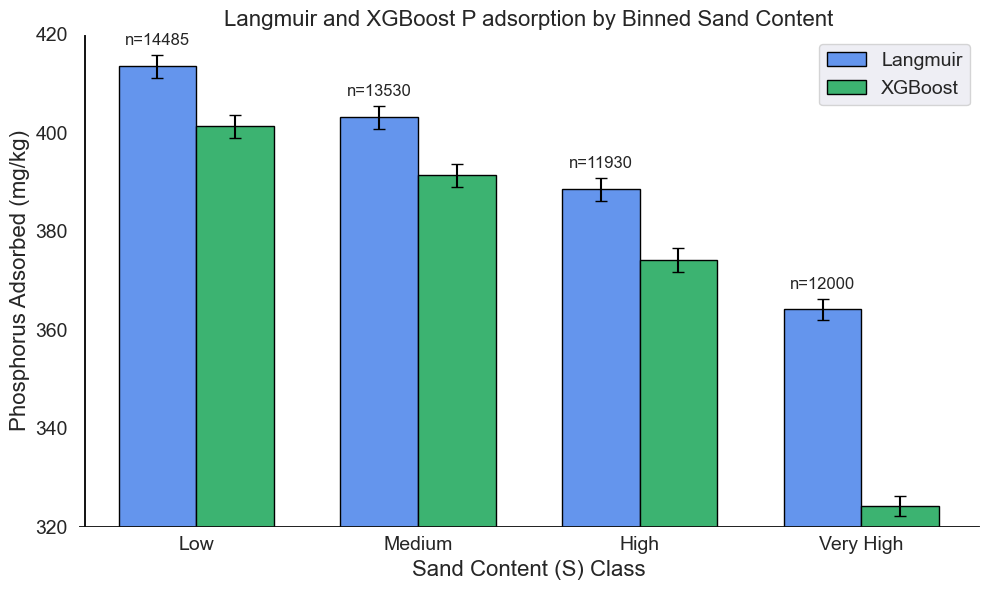

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Bin Sand (S) into 4 quantile-based classes ---
df_final2['S_bin'] = pd.qcut(df_final2['S'], q=4, labels=["Low", "Medium", "High", "Very High"])

# --- Step 2: Group and summarize ---
summary = df_final2.groupby('S_bin').agg(
    P_adsorption_mean=('Langmuir', 'mean'),
    P_adsorption_sem=('Langmuir', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    q_mean=('XGBoost', 'mean'),
    q_sem=('XGBoost', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    n=('XGBoost', 'count')
).reset_index()

# --- Step 3: Plot bar chart with error bars ---
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

x = np.arange(len(summary))
width = 0.35

# Plot bars
ax.bar(x - width/2, summary['P_adsorption_mean'], width,
       yerr=summary['P_adsorption_sem'], capsize=4,
       label='Langmuir', color='cornflowerblue', edgecolor='black')

ax.bar(x + width/2, summary['q_mean'], width,
       yerr=summary['q_sem'], capsize=4,
       label='XGBoost', color='mediumseagreen', edgecolor='black')

# Labels and styling
ax.set_xticks(x)
ax.set_xticklabels(summary['S_bin'], fontsize=14)
ax.set_ylabel("Phosphorus Adsorbed (mg/kg)", fontsize=16)
ax.set_xlabel("Sand Content (S) Class", fontsize=16)
ax.set_title("Langmuir and XGBoost P adsorption by Binned Sand Content", fontsize=16)
ax.legend(fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(320, 420)

# Draw X and Y axis lines
ax.axhline(y=320, color='black', linewidth=1.3)
ax.axvline(x=-0.5, color='black', linewidth=1.3)  # start of x-axis

# Annotate sample size
for i, row in summary.iterrows():
    ax.text(x[i] - width/2, row['P_adsorption_mean'] + row['P_adsorption_sem'] + 2,
            f"n={row['n']}", ha='center', fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


In [46]:
print(summary)

       S_bin  P_adsorption_mean  P_adsorption_sem      q_mean     q_sem      n
0        Low         413.516183          2.330699  401.339446  2.287025  14485
1     Medium         403.143164          2.348936  391.343193  2.345800  13530
2       High         388.511794          2.365930  374.157747  2.382103  11930
3  Very High         364.116955          2.175324  324.206620  1.993854  12000


In [48]:
# Filter the two groups
low_group = df_final2[df_final2['S_bin'] == 'Low']['Langmuir'].dropna()
very_high_group = df_final2[df_final2['S_bin'] == 'Very High']['Langmuir'].dropna()

# Perform one-way ANOVA
f_stat, p_value = f_oneway(low_group, very_high_group)

print(f"ANOVA results:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")

ANOVA results:
F-statistic = 232.912, p-value = 0.00000


In [49]:
# Filter the two groups
low_group = df_final2[df_final2['S_bin'] == 'Low']['XGBoost'].dropna()
very_high_group = df_final2[df_final2['S_bin'] == 'Very High']['XGBoost'].dropna()

# Perform one-way ANOVA
f_stat, p_value = f_oneway(low_group, very_high_group)

print(f"ANOVA results:\nF-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")

ANOVA results:
F-statistic = 619.280, p-value = 0.00000


In [50]:
# Extract the bin edges used by qcut
bins = pd.qcut(df_final2['S'], q=4, retbins=True)[1]
print("Sand content (S) bin edges:", bins)

Sand content (S) bin edges: [ 4. 30. 44. 56. 94.]


In [51]:
# Get the bin edges used for P_bin
_, p_bins = pd.qcut(df_final2['P'], q=4, retbins=True)
print("P (Olsen phosphorus) bin edges:", p_bins)

P (Olsen phosphorus) bin edges: [  1.     6.83  12.89  25.77 360.44]


In [52]:
# | Bin | Range (P values in mg/kg) | Label       |
# | --- | ------------------------- | ----------- |
# | 1   | 1.0 – 6.83                | "Low"       |
# | 2   | >6.83 – 12.89             | "Medium"    |
# | 3   | >12.89 – 25.77            | "High"      |
# | 4   | >25.77 – 360.44           | "Very High" |

In [53]:
max_p = df_final2['P'].max()
print("Maximum P value:", max_p)

Maximum P value: 360.44


In [55]:
url = "https://zenodo.org/record/15854383/files/percentage_adsorption.xlsx"
df = pd.read_excel(url)

df.head()

,Α/Α,Α.Μ.Δ.Ε.,C,Si,S,pH,EC,CaCO3,O.M.,P,ΑΡΧΙΚΟΣ OLSEN,PAU,PFU,Percentage adsorption,a/a,Soil texture,Soil Classification,Ce
0,1,2298,38,32,30,4.85,0.125,0.0,1.97,15.34,9.465,4.80900,4.809000,100.000,2298,CL,Clayey,1
1,2,2299A,42,28,30,5.51,0.205,0.0,3.03,21.85,14.001,4.67160,4.232983,90.611,2299A,C,Clayey,1
2,3,2299B,42,28,30,5.51,0.205,0.0,3.03,21.85,13.040,4.67160,4.390603,93.985,2299B,C,Clayey,1
3,4,2334,48,24,28,5.67,0.239,0.0,1.86,10.60,16.687,4.67160,4.627173,99.049,2334,C,Clayey,1
4,5,1665,44,32,24,5.70,0.116,0.0,2.64,16.46,8.762,4.56855,4.535565,99.278,1665,C,Clayey,1


In [56]:
# # Calculate the mean percentage of phosphorus adsorption for each soil classification across Ce levels
# Group by 'Soil classification' and 'Ce', then calculate the mean
mean_adsorption = df.groupby(['Soil Classification', 'Ce'])['Percentage adsorption'].mean().reset_index()

# Optionally, pivot the table to better view the results
pivot_table = mean_adsorption.pivot(index='Soil Classification', columns='Ce', values='Percentage adsorption')

print(pivot_table)


Ce                          1          2          4          6          10
Soil Classification                                                       
Clayey               97.095814  92.137651  91.353116  90.342337  87.726484
Loamy                87.277226  91.103048  89.937331  90.376467  86.511856
Sandy                73.679283  81.820446  81.146728  84.256667  77.780546


In [57]:
# calculate std by soil classification
pivot_std = df.groupby(['Soil Classification', 'Ce'])['Percentage adsorption'].std().reset_index()
pivot_std = pivot_std.pivot(index='Soil Classification', columns='Ce', values='Percentage adsorption')
print(pivot_std)

Ce                          1          2          4          6          10
Soil Classification                                                       
Clayey                6.071450  10.589844  10.395930   9.483822  10.252778
Loamy                10.384047   6.547037   7.015029   7.163288   9.731785
Sandy                23.811501  17.748809  19.083799  11.980880  12.767621


In [58]:
# calculate mean percentage adsorption by soil texture
# Group by 'Soil classification' and 'Ce', then calculate the mean
mean_adsorption = df.groupby(['Soil texture', 'Ce'])['Percentage adsorption'].mean().reset_index()

# Optionally, pivot the table to better view the results
pivot_table = mean_adsorption.pivot(index='Soil texture', columns='Ce', values='Percentage adsorption')

print(pivot_table)

Ce                   1          2          4          6          10
Soil texture                                                       
C             98.195143  93.566381  93.309310  92.376452  91.215286
CL            92.284229  91.755657  90.664607  90.596814  87.518857
L             81.841950  88.445875  86.588794  88.455206  83.613703
LS            52.623500  68.249000  62.193875  63.350250  55.840600
SCL           86.760923  90.141923  89.435923  87.702833  83.785438
SL            75.684087  83.183783  81.737065  83.411007  75.123230
SiC           98.457000  87.336500  86.435375  85.942500  80.968950
SiCL          99.757500  91.771750  93.813875  91.459083  86.180450
SiL           79.963769  83.083462  85.633365  90.367096  86.740377


In [59]:
#calculate std by soil texture
pivot_std = df.groupby(['Soil texture', 'Ce'])['Percentage adsorption'].std().reset_index()
pivot_std = pivot_std.pivot(index='Soil texture', columns='Ce', values='Percentage adsorption')
print(pivot_std)

Ce                   1          2          4          6          10
Soil texture                                                       
C              3.484033  11.112007  10.149621   9.649184   7.565180
CL             8.234434   7.964432   8.208744   7.596760   9.685624
L             17.201578   9.283196  15.453272   7.883638   9.822059
LS             9.911516  31.651514  23.179491  27.853290  27.889564
SCL           11.075637   6.906065   6.660660   8.655595  10.983591
SL            23.252040  17.285859  17.230574  12.007069  12.919017
SiC            0.680237  13.946267  17.689160  17.938828  23.306169
SiCL           0.342947   8.089655   4.213119   4.445698   6.307322
SiL           24.869995  21.068028  12.527781   7.685734   7.424554


In [60]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from collections import defaultdict

# Example: run this for each Ce level
letters_dict = {}

for ce_level in df['Ce'].unique():
    sub_df = df[df['Ce'] == ce_level]

    # ANOVA
    model = ols('Q("Percentage adsorption") ~ C(Q("Soil texture"))', data=sub_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Tukey HSD
    mc = MultiComparison(sub_df['Percentage adsorption'], sub_df['Soil texture'])
    tukey_result = mc.tukeyhsd()

    # Extract group letters
    summary_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    groups = mc.groupsunique
    reject_dict = defaultdict(set)

    for i, row in summary_df.iterrows():
        if not row['reject']:
            # Not significantly different -> share a group
            reject_dict[row['group1']].add(row['group2'])
            reject_dict[row['group2']].add(row['group1'])

    # Assign letters (simplified greedy algorithm)
    group_letters = {}
    used_letters = []
    for group in sorted(groups):
        assigned = False
        for letter in used_letters:
            if all(g not in reject_dict[group] for g, l in group_letters.items() if l == letter):
                group_letters[group] = letter
                assigned = True
                break
        if not assigned:
            new_letter = chr(97 + len(used_letters))  # 'a', 'b', 'c', ...
            group_letters[group] = new_letter
            used_letters.append(new_letter)

    letters_dict[ce_level] = group_letters

# Example output
for ce, letter_map in letters_dict.items():
    print(f"Ce = {ce} mg/L")
    for soil_class, letter in letter_map.items():
        print(f"  {soil_class}: {letter}")


Ce = 1 mg/L
  C: a
  CL: b
  L: a
  LS: b
  SCL: c
  SL: d
  SiC: e
  SiCL: f
  SiL: g
Ce = 2 mg/L
  C: a
  CL: b
  L: c
  LS: d
  SCL: e
  SL: f
  SiC: g
  SiCL: h
  SiL: i
Ce = 4 mg/L
  C: a
  CL: b
  L: c
  LS: a
  SCL: d
  SL: e
  SiC: f
  SiCL: g
  SiL: h
Ce = 6 mg/L
  C: a
  CL: b
  L: c
  LS: a
  SCL: d
  SL: e
  SiC: f
  SiCL: g
  SiL: h
Ce = 10 mg/L
  C: a
  CL: b
  L: c
  LS: a
  SCL: d
  SL: b
  SiC: e
  SiCL: f
  SiL: g


In [61]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from collections import defaultdict

# Example: run this for each Ce level
letters_dict = {}

for ce_level in df['Ce'].unique():
    sub_df = df[df['Ce'] == ce_level]

    # ANOVA
    model = ols('Q("Percentage adsorption") ~ C(Q("Soil Classification"))', data=sub_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Tukey HSD
    mc = MultiComparison(sub_df['Percentage adsorption'], sub_df['Soil Classification'])
    tukey_result = mc.tukeyhsd()

    # Extract group letters
    summary_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    groups = mc.groupsunique
    reject_dict = defaultdict(set)

    for i, row in summary_df.iterrows():
        if not row['reject']:
            # Not significantly different -> share a group
            reject_dict[row['group1']].add(row['group2'])
            reject_dict[row['group2']].add(row['group1'])

    # Assign letters (simplified greedy algorithm)
    group_letters = {}
    used_letters = []
    for group in sorted(groups):
        assigned = False
        for letter in used_letters:
            if all(g not in reject_dict[group] for g, l in group_letters.items() if l == letter):
                group_letters[group] = letter
                assigned = True
                break
        if not assigned:
            new_letter = chr(97 + len(used_letters))  # 'a', 'b', 'c', ...
            group_letters[group] = new_letter
            used_letters.append(new_letter)

    letters_dict[ce_level] = group_letters

# Example output
for ce, letter_map in letters_dict.items():
    print(f"Ce = {ce} mg/L")
    for soil_class, letter in letter_map.items():
        print(f"  {soil_class}: {letter}")


Ce = 1 mg/L
  Clayey : a
  Loamy: a
  Sandy: a
Ce = 2 mg/L
  Clayey : a
  Loamy: b
  Sandy: a
Ce = 4 mg/L
  Clayey : a
  Loamy: b
  Sandy: a
Ce = 6 mg/L
  Clayey : a
  Loamy: b
  Sandy: a
Ce = 10 mg/L
  Clayey : a
  Loamy: b
  Sandy: a


In [64]:
df_expanded = df_cleaned.copy()

In [65]:
df_expanded.rename(columns={'O.O.': 'Organic matter', 'Ec': 'EC'}, inplace=True)

In [66]:
X_input = df_expanded[['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu']]

In [67]:
df_expanded.shape

(10392, 23)

In [68]:
nan_counts = df_expanded.isna().sum()
print("NaN count per column:")
print(nan_counts[nan_counts > 0])  # show only columns with NaNs

NaN count per column:
Series([], dtype: int64)


In [69]:
y_pred = model_multi.predict(X_input)

In [70]:
# 1. Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['XGBoost_1ppm_adsorbed', 'XGBoost_2ppm_adsorbed', 'XGBoost_4ppm_adsorbed', 'XGBoost_6ppm_adsorbed', 'XGBoost_10ppm_adsorbed'])

In [71]:
# 2. Reset index (optional, if needed for alignment)
y_pred_df.reset_index(drop=True, inplace=True)
df_expanded.reset_index(drop=True, inplace=True)

# 3. Concatenate to df_final
df_expanded = pd.concat([df_expanded, y_pred_df], axis=1)

In [72]:
df_expanded = df_expanded[~df_expanded['Α.Μ.Δ'].isin(['212785', '192470', '193250'])]

In [73]:
print(df_expanded.shape)

(10389, 28)


In [74]:
# Calculate part A based on given formula
partA = 0.278 * (df_expanded['S'] / 100) + 0.034 * (df_expanded['C'] / 100) + 0.022 * df_expanded['Organic matter'] - 0.018 * (
        (df_expanded['S'] / 100) * df_expanded['Organic matter']) - 0.027 * ((df_expanded['C'] / 100) * df_expanded['Organic matter']) - 0.584 * (
                (df_expanded['S'] / 100) * (df_expanded['C'] / 100)) + 0.078

# Calculate part B, enhancing part A with additional operations
partB = partA + 0.636 * partA - 0.107

# Calculate part C with a difZnrent set of operations and factors
partC = -0.251 * (df_expanded['S'] / 100) + 0.195 * (df_expanded['C'] / 100) + 0.011 * df_expanded['Organic matter'] + 0.006 * (
        (df_expanded['S'] / 100) * df_expanded['Organic matter']) - 0.027 * ((df_expanded['C'] / 100) * df_expanded['Organic matter']) + 0.452 * (
                (df_expanded['S'] / 100) * (df_expanded['C'] / 100)) + 0.299

# Enhance part C with additional operations to calculate part D
partD = partC + 1.283 * partC * partC - 0.374 * partC - 0.015

# Combine parts D and B and adjust with additional operations to calculate part E
partE = partD + partB - 0.097 * (df_expanded['S'] / 100) + 0.043

# Final calculation for FEB, scaling the result of (1 - partE) by 2
df_expanded['FEB'] = (1 - partE) * 2.65

In [75]:
# create columns with Phosphorus applied in kg/stremma for equilibrium concentrations 1, 2, 4, 6, and 10 mg/L
df_expanded['1ppm_applied'] = 30*(1/1000)*(1000/3)*2.29*(1000*0.15*df_expanded['FEB']*1000/1000000)
df_expanded['2ppm_applied'] = 30*(2/1000)*(1000/3)*2.29*(1000*0.15*df_expanded['FEB']*1000/1000000)
df_expanded['4ppm_applied'] = 30*(4/1000)*(1000/3)*2.29*(1000*0.15*df_expanded['FEB']*1000/1000000)
df_expanded['6ppm_applied'] = 30*(6/1000)*(1000/3)*2.29*(1000*0.15*df_expanded['FEB']*1000/1000000)
df_expanded['10ppm_applied'] = 30*(10/1000)*(1000/3)*2.29*(1000*0.15*df_expanded['FEB']*1000/1000000)

In [76]:
# convert applied P to mg/kg of soil
df_expanded['1ppm_applied'] = (df_expanded['1ppm_applied']*0.4364*1000000)/(df_expanded['FEB']*15*10000)
df_expanded['2ppm_applied'] = (df_expanded['2ppm_applied']*0.4364*1000000)/(df_expanded['FEB']*15*10000)
df_expanded['4ppm_applied'] = (df_expanded['4ppm_applied']*0.4364*1000000)/(df_expanded['FEB']*15*10000)
df_expanded['6ppm_applied'] = (df_expanded['6ppm_applied']*0.4364*1000000)/(df_expanded['FEB']*15*10000)
df_expanded['10ppm_applied'] = (df_expanded['10ppm_applied']*0.4364*1000000)/(df_expanded['FEB']*15*10000)

In [77]:
# convert from stremma to ha
df_expanded['1ppm_applied'] = 10 * df_expanded['1ppm_applied']
df_expanded['2ppm_applied'] = 10 * df_expanded['2ppm_applied']
df_expanded['4ppm_applied'] = 10 * df_expanded['4ppm_applied']
df_expanded['6ppm_applied'] = 10 * df_expanded['6ppm_applied']
df_expanded['10ppm_applied'] = 10 * df_expanded['10ppm_applied']

In [78]:
# calculate percentage adsorption
df_expanded['PFP1'] = round(df_expanded['XGBoost_1ppm_adsorbed']*100/df_expanded['1ppm_applied'],1)
df_expanded['PFP2'] = round(df_expanded['XGBoost_2ppm_adsorbed']*100/df_expanded['2ppm_applied'],1)
df_expanded['PFP4'] = round(df_expanded['XGBoost_4ppm_adsorbed']*100/df_expanded['4ppm_applied'],1)
df_expanded['PFP6'] = round(df_expanded['XGBoost_6ppm_adsorbed']*100/df_expanded['6ppm_applied'],1)
df_expanded['PFP10'] = round(df_expanded['XGBoost_10ppm_adsorbed']*100/df_expanded['10ppm_applied'],1)

In [79]:
# Langmuir parameters
texture_params = {
    "C":    (16366.058934, 0.005949),
    "CL":   (14959.937394, 0.006133),
    "L":    (12055.405405, 0.007546),
    "LS":   (2803.550024, 0.025078),
    "SCL":  (8517.247429, 0.010916),
    "SL":   (4998.743467, 0.017967),
    "SiC":  (6686.859738, 0.013785),
    "SiCL": (6840.715595, 0.014428),
    "SiL":  (104509.787289, 0.000841)
}

classification_params = {
    "Clayey": (11822.862819, 0.007950),
    "Loamy":  (12899.800247, 0.007242),
    "Sandy":  (8231.606950, 0.010547)
}

# Langmuir function
def langmuir(Ce, Qm, K):
    return (Qm * K * Ce) / (1 + K * Ce)

# Ce values
Ce_values = [1, 2, 4, 6, 10]

# Mapping Ce to XGBoost column
ce_to_xgb_col = {
    1: 'PFP1',
    2: 'PFP2',
    4: 'PFP4',
    6: 'PFP6',
    10: 'PFP10'
}

# Collect new rows
expanded_predictions = []

for _, row in df_expanded.iterrows():
    texture = row['Soil texture']
    classification = row['Soil Classification']

    if texture in texture_params:
        Qm, K = texture_params[texture]
        used = 'Texture'
        used_texture_param = True
    elif classification in classification_params:
        Qm, K = classification_params[classification]
        used = 'Classification'
        used_texture_param = False
    else:
        Qm, K = np.nan, np.nan
        used = 'None'
        used_texture_param = np.nan

    for Ce in Ce_values:
        if not np.isnan(Qm):
            q = langmuir(Ce, Qm, K)
        else:
            q = np.nan

        # Get corresponding XGBoost prediction
        xgb_col = ce_to_xgb_col[Ce]
        xgb_pred = row.get(xgb_col, np.nan)

        # Copy row and add values
        new_row = row.copy()
        new_row['Ce'] = Ce
        new_row['P_adsorption'] = q
        new_row['PFP'] = xgb_pred
        new_row['Used Params From'] = used
        new_row['Used Texture Params'] = used_texture_param

        expanded_predictions.append(new_row)

# Final expanded dataframe
df_expanded_10 = pd.DataFrame(expanded_predictions)


In [80]:
df = df_expanded_10.copy()

In [81]:
# calculate percentage adsorption by soil texture for the extended dataset
# Group by 'Soil classification' and 'Ce', then calculate the mean
mean_adsorption = df.groupby(['Soil texture', 'Ce'])['PFP'].mean().reset_index()

# Optionally, pivot the table to better view the results
pivot_table = mean_adsorption.pivot(index='Soil texture', columns='Ce', values='PFP')

print(pivot_table)

Ce                   1          2          4          6          10
Soil texture                                                       
C             91.129203  89.693934  88.758232  88.495407  85.118371
CL            83.628734  87.032248  86.808734  87.730129  84.671421
L             76.861095  84.287623  83.072189  85.590878  82.204142
LS            76.352571  76.874857  65.749143  69.815429  61.624571
S             76.596774  76.916129  65.435484  69.751613  61.151613
SC            81.545000  85.440000  84.345000  85.755000  82.295000
SCL           77.697975  83.952981  82.573791  83.555681  79.430709
SL            74.433787  78.690681  73.797068  76.346003  70.198499
SiC           93.567630  89.712717  89.216185  88.634682  84.746821
SiCL          93.113382  90.706083  90.380535  90.105596  86.380535
SiL           84.609322  87.916102  87.238983  88.965113  85.368644


In [82]:
# calculate std by soil texture for the extended dataset
pivot_std = df.groupby(['Soil texture', 'Ce'])['PFP'].std().reset_index()
pivot_std = pivot_std.pivot(index='Soil texture', columns='Ce', values='PFP')
print(pivot_std)

Ce                   1          2          4         6          10
Soil texture                                                      
C             12.867078   8.450598   8.173876  7.570804   7.380424
CL            14.649420   8.886777   7.940832  6.499603   6.314507
L             14.397276   8.774223   8.634004  6.882619   7.027112
LS            10.900226   9.501945   7.350017  7.582704   7.316264
S             11.113730  10.177593   5.087340  7.632600   6.590745
SC            10.079812   6.347764   6.346858  3.257134   3.266976
SCL           12.688274   7.967966   8.211009  6.466159   6.774589
SL            12.842221   9.838483  10.365182  9.829733  10.697628
SiC           10.028424   7.007443   7.674450  7.315996   7.195376
SiCL           9.507622   5.705666   5.841250  5.412731   5.526642
SiL           13.914402   7.225804   6.719273  5.045399   5.320469


In [83]:
df = df.rename(columns={'Soil texture': 'Soil_texture'})

In [84]:
df = df.rename(columns={'Organic matter': 'Organic_matter'})

In [85]:
df = df.rename(columns={'C': 'Clay'})

In [86]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from collections import defaultdict

# Example: run this for each Ce level
letters_dict = {}

for ce_level in df['Ce'].unique():
    sub_df = df[df['Ce'] == ce_level]

    # ANOVA
    model = ols('PFP ~ C(Soil_texture)', data=sub_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Tukey HSD
    mc = MultiComparison(sub_df['PFP'], sub_df['Soil_texture'])
    tukey_result = mc.tukeyhsd()

    # Extract group letters
    summary_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    groups = mc.groupsunique
    reject_dict = defaultdict(set)

    for i, row in summary_df.iterrows():
        if not row['reject']:
            # Not significantly different -> share a group
            reject_dict[row['group1']].add(row['group2'])
            reject_dict[row['group2']].add(row['group1'])

    # Assign letters (simplified greedy algorithm)
    group_letters = {}
    used_letters = []
    for group in sorted(groups):
        assigned = False
        for letter in used_letters:
            if all(g not in reject_dict[group] for g, l in group_letters.items() if l == letter):
                group_letters[group] = letter
                assigned = True
                break
        if not assigned:
            new_letter = chr(97 + len(used_letters))  # 'a', 'b', 'c', ...
            group_letters[group] = new_letter
            used_letters.append(new_letter)

    letters_dict[ce_level] = group_letters

# Example output
for ce, letter_map in letters_dict.items():
    print(f"Ce = {ce} mg/L")
    for soil_class, letter in letter_map.items():
        print(f"  {soil_class}: {letter}")


C:\Users\miatr\Documents\fastai\venv\lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Ce = 1 mg/L
  C: a
  CL: a
  L: a
  LS: b
  S: c
  SC: d
  SCL: e
  SL: a
  SiC: b
  SiCL: c
  SiL: b
Ce = 2 mg/L
  C: a
  CL: a
  L: a
  LS: a
  S: b
  SC: b
  SCL: c
  SL: c
  SiC: c
  SiCL: d
  SiL: d
Ce = 4 mg/L
  C: a
  CL: a
  L: a
  LS: a
  S: b
  SC: b
  SCL: c
  SL: a
  SiC: c
  SiCL: a
  SiL: d
Ce = 6 mg/L
  C: a
  CL: b
  L: a
  LS: a
  S: b
  SC: c
  SCL: a
  SL: a
  SiC: d
  SiCL: a
  SiL: b
Ce = 10 mg/L
  C: a
  CL: b
  L: a
  LS: a
  S: b
  SC: c
  SCL: a
  SL: a
  SiC: d
  SiCL: b
  SiL: e
